<a href="https://colab.research.google.com/github/SamuelEkpe/Personalized_Medicine_for_CVD_Management/blob/mba_cvd/mba_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalized Medicine for CAD using MBA and ML
# This notebook performs data preprocessing, market basket analysis, rule mining,model training with cross-validation, and patient segmentation.



In [ ]:
# Important Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from mlxtend.frequent_patterns import apriori,fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) # To enable the display of all cols in the df





In [ ]:
from google.colab import drive
drive.mount('/content/drive') # to mount the my google drive for connection

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/african_population_cad_enriched_with_triage.csv'


In [ ]:
# Cell 3: Load and Preview Dataset
df = pd.read_csv(file_path, encoding='utf-8', delimiter=',', header=0, skip_blank_lines=True)
df =df.sort_values(by='Age', ascending  =False).reset_index(drop =True)
df.head(19)


,Age,Sex,Region,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Smoking_Status,Diabetes,Hypertension,Physical_Activity,Family_History_CAD,Alcohol_Use,CAD_Status,APOE_E4,LDLR_mutation,PCSK9_variant,hs_CRP,Statin_Use,LDL_Response,Medication_Adherence,Education_Level,Healthcare_Access,Diet_Quality,Stress_Level,Chest_Pain_Type,Chest_Pain_Severity,Shortness_of_Breath,Palpitations,Dizziness,Fatigue,ECG_Abnormality,Troponin_Level
0,84,Male,East Africa,28.4,120,96,5.2,1.5,3.7,2.8,Never,No,Yes,Low,Yes,Moderate,1,1,0,0,2.28,Yes,3.0,High,Primary,Fair,Poor,Low,Typical,3,No,No,No,No,T-wave inversion,0.009
1,84,Male,North Africa,23.7,118,76,3.8,0.9,2.2,1.6,Former,No,No,High,No,High,0,2,0,0,4.14,No,2.2,Moderate,Primary,Fair,Poor,Low,NaN,0,No,No,No,No,Other,0.039
2,84,Female,East Africa,29.4,157,76,7.3,1.3,5.5,1.1,Never,No,Yes,High,No,Moderate,0,0,0,0,2.94,Yes,4.3,Moderate,Secondary,Fair,Average,Low,Atypical,2,No,No,No,Yes,Normal,0.005
3,84,Male,Central Africa,31.9,162,109,5.0,0.8,3.1,2.5,Former,No,Yes,Low,Yes,NaN,1,0,0,0,2.26,Yes,2.3,High,Primary,Poor,Average,High,NaN,0,No,No,No,No,T-wave inversion,0.000
4,84,Male,Central Africa,26.4,134,99,7.6,1.1,3.3,1.7,Never,No,Yes,Low,No,NaN,1,0,0,1,3.37,No,3.3,High,Primary,Fair,Average,Low,NaN,0,Yes,Yes,No,No,Normal,0.004
5,84,Female,East Africa,21.9,151,71,3.3,1.1,2.3,0.1,Never,No,Yes,Low,Yes,Moderate,0,0,0,0,1.50,No,2.3,High,NaN,Poor,Average,Low,NaN,0,No,No,No,Yes,Normal,0.004
6,84,Male,North Africa,23.3,166,109,5.2,1.5,6.5,1.6,Never,No,Yes,High,No,NaN,1,0,0,0,1.56,No,6.5,High,Secondary,Good,Average,Moderate,Non-anginal,1,No,Yes,Yes,No,Other,0.153
7,84,Female,West Africa,16.9,128,75,5.4,1.7,1.9,2.2,Never,No,No,Moderate,No,NaN,0,0,0,0,2.98,No,1.9,High,Primary,Good,Good,High,NaN,0,No,No,No,Yes,Normal,0.122
8,84,Female,Central Africa,24.6,131,93,4.3,1.5,2.3,2.2,Never,No,Yes,Moderate,Yes,NaN,1,1,0,0,2.00,Yes,1.9,Moderate,Secondary,Fair,Average,Moderate,Non-anginal,1,Yes,No,No,No,Normal,0.006
9,84,Female,East Africa,23.4,179,102,5.4,1.2,3.4,1.7,Never,No,Yes,Moderate,No,Moderate,1,0,1,0,0.61,No,3.4,Moderate,Secondary,Fair,Good,Low,NaN,0,No,No,No,No,Normal,0.029


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  int64  
 1   Sex                   10000 non-null  object 
 2   Region                10000 non-null  object 
 3   BMI                   10000 non-null  float64
 4   Systolic_BP           10000 non-null  int64  
 5   Diastolic_BP          10000 non-null  int64  
 6   Total_Cholesterol     10000 non-null  float64
 7   HDL_Cholesterol       10000 non-null  float64
 8   LDL_Cholesterol       10000 non-null  float64
 9   Triglycerides         10000 non-null  float64
 10  Smoking_Status        10000 non-null  object 
 11  Diabetes              10000 non-null  object 
 12  Hypertension          10000 non-null  object 
 13  Physical_Activity     10000 non-null  object 
 14  Family_History_CAD    10000 non-null  object 
 15  Alcohol_Use         

# Data Cleaning
1. Removing Outliers
2. Filling Nulls
3. Converting cholesterols from mmol/l to mg/dl
4. Grouping numeric features for MBA

Data Preprocessing
To Convert Total_Cholesterol, HDL_Cholesterol, LDL_Cholesterol and Triglycerids from mmol/L to mg/dl
cholesterol(mg/dl) = cholesterol(mmol/L )*38.67
triglycerides(mg/dl) = triglyceride(mmol/l)* 88.57

In [ ]:
df[['Total_Cholesterol','HDL_Cholesterol','LDL_Cholesterol','LDL_Response']] = df[['Total_Cholesterol',
                                                                                   'HDL_Cholesterol','LDL_Cholesterol','LDL_Response']]* 38.67
df['Triglycerides'] = df['Triglycerides'] * 88.57


In [ ]:
df.describe()

,Age,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,CAD_Status,APOE_E4,LDLR_mutation,PCSK9_variant,hs_CRP,LDL_Response,Chest_Pain_Severity,Troponin_Level
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,57.170900,27.018790,144.070400,89.518900,213.325762,46.408640,135.983442,150.235977,0.479500,0.348500,0.099500,0.147800,2.509085,122.636491,1.323700,0.024336
std,15.876546,3.945067,20.286246,11.585407,46.277209,11.804888,38.560561,71.151782,0.499605,0.568753,0.299347,0.354919,1.188974,39.149976,1.227546,0.037970
min,30.000000,13.000000,110.000000,70.000000,11.601000,7.734000,-27.069000,-168.283000,0.000000,0.000000,0.000000,0.000000,-2.050000,-15.468000,0.000000,0.000000
25%,44.000000,24.300000,127.000000,79.000000,181.749000,38.670000,108.276000,106.284000,0.000000,0.000000,0.000000,0.000000,1.700000,92.808000,0.000000,0.005000
50%,57.000000,27.000000,144.000000,90.000000,212.685000,46.404000,135.345000,150.569000,0.000000,0.000000,0.000000,0.000000,2.500000,119.877000,1.000000,0.012000
75%,71.000000,29.700000,162.000000,99.000000,243.621000,54.138000,162.414000,194.854000,1.000000,1.000000,0.000000,0.000000,3.300000,146.946000,3.000000,0.021000
max,84.000000,42.800000,179.000000,109.000000,375.099000,88.941000,270.690000,416.279000,1.000000,2.000000,1.000000,1.000000,7.270000,270.690000,3.000000,0.243000


In [ ]:
# using Total_cholesterol to handle outliers
df = df[(df['Total_Cholesterol'] >= 100) & (df['Total_Cholesterol'] <= 400)]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9926 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9926 non-null   int64  
 1   Sex                   9926 non-null   object 
 2   Region                9926 non-null   object 
 3   BMI                   9926 non-null   float64
 4   Systolic_BP           9926 non-null   int64  
 5   Diastolic_BP          9926 non-null   int64  
 6   Total_Cholesterol     9926 non-null   float64
 7   HDL_Cholesterol       9926 non-null   float64
 8   LDL_Cholesterol       9926 non-null   float64
 9   Triglycerides         9926 non-null   float64
 10  Smoking_Status        9926 non-null   object 
 11  Diabetes              9926 non-null   object 
 12  Hypertension          9926 non-null   object 
 13  Physical_Activity     9926 non-null   object 
 14  Family_History_CAD    9926 non-null   object 
 15  Alcohol_Use           5057

In [ ]:
# bounding value limits
df['LDL_Cholesterol'] = df['LDL_Cholesterol'].clip(lower=40, upper=300)
df['HDL_Cholesterol'] = df['HDL_Cholesterol'].clip(lower=20, upper=100)
df['Triglycerides'] = df['Triglycerides'].clip(lower=40, upper=500)
df['LDL_Response'] = df['LDL_Response'].clip(lower =0, upper =10)

df.describe()

,Age,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,CAD_Status,APOE_E4,LDLR_mutation,PCSK9_variant,hs_CRP,LDL_Response,Chest_Pain_Severity,Troponin_Level
count,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000
mean,57.155148,27.023504,144.065485,89.519948,214.296705,46.470333,136.061837,152.089320,0.480153,0.347874,0.099436,0.147693,2.508607,9.997529,1.324199,0.024375
std,15.862047,3.944849,20.282169,11.578307,45.039327,11.658234,38.378749,67.475897,0.499631,0.568332,0.299261,0.354813,1.189705,0.145533,1.227753,0.038027
min,30.000000,13.000000,110.000000,70.000000,100.542000,20.000000,40.000000,40.000000,0.000000,0.000000,0.000000,0.000000,-2.050000,0.000000,0.000000,0.000000
25%,44.000000,24.300000,127.000000,79.250000,181.749000,38.670000,108.276000,106.284000,0.000000,0.000000,0.000000,0.000000,1.700000,10.000000,0.000000,0.005000
50%,57.000000,27.000000,144.000000,90.000000,212.685000,46.404000,135.345000,150.569000,0.000000,0.000000,0.000000,0.000000,2.500000,10.000000,1.000000,0.012000
75%,71.000000,29.700000,162.000000,99.000000,243.621000,54.138000,162.414000,194.854000,1.000000,1.000000,0.000000,0.000000,3.300000,10.000000,3.000000,0.022000
max,84.000000,42.800000,179.000000,109.000000,375.099000,88.941000,270.690000,416.279000,1.000000,2.000000,1.000000,1.000000,7.270000,10.000000,3.000000,0.243000


## Handling Nulls

In [ ]:
print("Percentage of null is:\n", (df.isnull().mean() * 100).round(2).apply(lambda x: f"{x}%"))


Percentage of null is:
 Age                       0.0%
Sex                       0.0%
Region                    0.0%
BMI                       0.0%
Systolic_BP               0.0%
Diastolic_BP              0.0%
Total_Cholesterol         0.0%
HDL_Cholesterol           0.0%
LDL_Cholesterol           0.0%
Triglycerides             0.0%
Smoking_Status            0.0%
Diabetes                  0.0%
Hypertension              0.0%
Physical_Activity         0.0%
Family_History_CAD        0.0%
Alcohol_Use             49.05%
CAD_Status                0.0%
APOE_E4                   0.0%
LDLR_mutation             0.0%
PCSK9_variant             0.0%
hs_CRP                    0.0%
Statin_Use                0.0%
LDL_Response              0.0%
Medication_Adherence      0.0%
Education_Level         10.38%
Healthcare_Access         0.0%
Diet_Quality              0.0%
Stress_Level              0.0%
Chest_Pain_Type         38.92%
Chest_Pain_Severity       0.0%
Shortness_of_Breath       0.0%
Palpitations   

In [ ]:
ordinal_cats =['Physical_Activity','Alcohol_Use','Medication_Adherence','Education_Level','Healthcare_Access',
               'Diet_Quality','Stress_Level']
nominal_cats =['Sex','Region','Smoking_Status','Diabetes','Hypertension','Family_History_CAD','Statin_Use',
               'Chest_Pain_Type','Shortness_of_Breath','Palpitations','Dizziness','Fatigue','ECG_Abnormality']

In [ ]:
numeric_df = df.select_dtypes(include =['float64','int64'])# to pick out numeric continuous features

# Handling Missing Values in Categorical Fe

In [ ]:
df['Chest_Pain_Type']=df['Chest_Pain_Type'].fillna(df['Chest_Pain_Type'].mode()[0])
df['Education_Level']=df['Education_Level'].fillna(df['Education_Level'].mode()[0])
df['Alcohol_Use']=df['Alcohol_Use'].fillna(df['Alcohol_Use'].mode()[0])



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9926 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9926 non-null   int64  
 1   Sex                   9926 non-null   object 
 2   Region                9926 non-null   object 
 3   BMI                   9926 non-null   float64
 4   Systolic_BP           9926 non-null   int64  
 5   Diastolic_BP          9926 non-null   int64  
 6   Total_Cholesterol     9926 non-null   float64
 7   HDL_Cholesterol       9926 non-null   float64
 8   LDL_Cholesterol       9926 non-null   float64
 9   Triglycerides         9926 non-null   float64
 10  Smoking_Status        9926 non-null   object 
 11  Diabetes              9926 non-null   object 
 12  Hypertension          9926 non-null   object 
 13  Physical_Activity     9926 non-null   object 
 14  Family_History_CAD    9926 non-null   object 
 15  Alcohol_Use           9926

In [ ]:
df['CAD_Status'] = df['CAD_Status'].astype('object')


In [ ]:
# mapping CAD_Status from 1,0 to Yes and NO
df['CAD_Status'] = df['CAD_Status'].map({1: 'YES', 0: 'NO'})


df['CAD_Status'].value_counts()


,count
CAD_Status,
NO,5160
YES,4766


In [ ]:
df.describe()

,Age,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,APOE_E4,LDLR_mutation,PCSK9_variant,hs_CRP,LDL_Response,Chest_Pain_Severity,Troponin_Level
count,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000
mean,57.155148,27.023504,144.065485,89.519948,214.296705,46.470333,136.061837,152.089320,0.347874,0.099436,0.147693,2.508607,9.997529,1.324199,0.024375
std,15.862047,3.944849,20.282169,11.578307,45.039327,11.658234,38.378749,67.475897,0.568332,0.299261,0.354813,1.189705,0.145533,1.227753,0.038027
min,30.000000,13.000000,110.000000,70.000000,100.542000,20.000000,40.000000,40.000000,0.000000,0.000000,0.000000,-2.050000,0.000000,0.000000,0.000000
25%,44.000000,24.300000,127.000000,79.250000,181.749000,38.670000,108.276000,106.284000,0.000000,0.000000,0.000000,1.700000,10.000000,0.000000,0.005000
50%,57.000000,27.000000,144.000000,90.000000,212.685000,46.404000,135.345000,150.569000,0.000000,0.000000,0.000000,2.500000,10.000000,1.000000,0.012000
75%,71.000000,29.700000,162.000000,99.000000,243.621000,54.138000,162.414000,194.854000,1.000000,0.000000,0.000000,3.300000,10.000000,3.000000,0.022000
max,84.000000,42.800000,179.000000,109.000000,375.099000,88.941000,270.690000,416.279000,2.000000,1.000000,1.000000,7.270000,10.000000,3.000000,0.243000


# **Grouping Features (Numeric) according to clinical thresholds**

In [ ]:
mba= df.copy()
mba['Age'] = pd.cut(mba['Age'], bins=[0, 44, 64, 120],
                         labels=['Young', 'Middle-aged', 'Elderly'], right=True)

mba['Systolic_BP'] = pd.cut(mba['Systolic_BP'], bins=[0, 119, 139,159, 300],
                         labels=['Normal', 'Elevated', 'Stage1 Hypertension','Stage2 Hypertension'], right=True)

mba['Diastolic_BP'] = pd.cut(mba['Diastolic_BP'], bins=[0, 79, 89,99, 200],
                         labels=['Normal', 'Elevated', 'Stage1 Hypertension','Stage2 Hypertension'], right=True)

mba['Total_Cholesterol'] = pd.cut(mba['Total_Cholesterol'], bins =[0,199,239,400],
labels=['Desirable','Borderline high','High'], right =True)

mba['BMI']= pd.cut(mba['BMI'], bins =[0,18.4,24.9,29.9,50],
                   labels=['Underweight','Normal','Overweight','Obese'], right=True)

mba['HDL_Cholesterol']= pd.cut(mba['HDL_Cholesterol'], bins =[0,39,59,100],
                               labels =['Low','Accesptable','Protective'], right =True)

mba['LDL_Cholesterol']=pd.cut(mba['LDL_Cholesterol'],bins =[0,99,129,159,189,300],
                              labels=['Optimal','Near Optimal','Borderline High','High','Very High'],right=True)

mba['Triglycerides']= pd.cut(mba['Triglycerides'], bins =[0,149,199,499,500],
                             labels =['Normal','Borderline','High','Very High'], right =True)
mba['hs_CRP'] = pd.cut(mba['hs_CRP'], bins =[0,0.9,3,20],
                       labels=['Low Risk', 'Average Risk','High Risk'])
mba['Troponin_Level'] = pd.cut(mba['Troponin_Level'],bins=[0, 0.04, 0.39, float('inf')],
    labels=['Normal', 'Borderline', 'High'], right =True)

mba['LDL_Response'] = pd.cut(mba['LDL_Response'],bins=[0, 2.0, 3.4, 4.9, float('inf')],
    labels=['Optimal Response', 'Near Optimal', 'Borderline Response', 'Poor Response'], right =True)








# Renaming labels for categorical features



In [ ]:
mba['APOE_E4']= mba['APOE_E4'].replace({0: 'Non-Carrier', 1: 'Carrier', 2: 'Carrier'})
mba['LDLR_mutation']= mba['LDLR_mutation'].replace({0:'Non-Carrier',1:'Carrier'})
mba['PCSK9_variant'] = mba['PCSK9_variant'].replace({0:'Non_Carrier',1:'Carrier'})
mba['Chest_Pain_Severity']=mba['Chest_Pain_Severity'].replace({0:'No Pain',1:'Mild',2:'Moderate',3:'Severe'})



In [ ]:
mba.head()

,Age,Sex,Region,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Smoking_Status,Diabetes,Hypertension,Physical_Activity,Family_History_CAD,Alcohol_Use,CAD_Status,APOE_E4,LDLR_mutation,PCSK9_variant,hs_CRP,Statin_Use,LDL_Response,Medication_Adherence,Education_Level,Healthcare_Access,Diet_Quality,Stress_Level,Chest_Pain_Type,Chest_Pain_Severity,Shortness_of_Breath,Palpitations,Dizziness,Fatigue,ECG_Abnormality,Troponin_Level
0,Elderly,Male,East Africa,Overweight,Elevated,Stage1 Hypertension,Borderline high,Accesptable,Borderline High,High,Never,No,Yes,Low,Yes,Moderate,YES,Carrier,Non-Carrier,Non_Carrier,Average Risk,Yes,Poor Response,High,Primary,Fair,Poor,Low,Typical,Severe,No,No,No,No,T-wave inversion,Normal
1,Elderly,Male,North Africa,Normal,Normal,Normal,Desirable,Low,Optimal,Normal,Former,No,No,High,No,High,NO,Carrier,Non-Carrier,Non_Carrier,High Risk,No,Poor Response,Moderate,Primary,Fair,Poor,Low,Typical,No Pain,No,No,No,No,Other,Normal
2,Elderly,Female,East Africa,Overweight,Stage1 Hypertension,Normal,High,Accesptable,Very High,Normal,Never,No,Yes,High,No,Moderate,NO,Non-Carrier,Non-Carrier,Non_Carrier,Average Risk,Yes,Poor Response,Moderate,Secondary,Fair,Average,Low,Atypical,Moderate,No,No,No,Yes,Normal,Normal
3,Elderly,Male,Central Africa,Obese,Stage2 Hypertension,Stage2 Hypertension,Desirable,Low,Near Optimal,High,Former,No,Yes,Low,Yes,Moderate,YES,Non-Carrier,Non-Carrier,Non_Carrier,Average Risk,Yes,Poor Response,High,Primary,Poor,Average,High,Typical,No Pain,No,No,No,No,T-wave inversion,NaN
4,Elderly,Male,Central Africa,Overweight,Elevated,Stage1 Hypertension,High,Accesptable,Near Optimal,Borderline,Never,No,Yes,Low,No,Moderate,YES,Non-Carrier,Non-Carrier,Carrier,High Risk,No,Poor Response,High,Primary,Fair,Average,Low,Typical,No Pain,Yes,Yes,No,No,Normal,Normal


In [ ]:
mba.isnull().sum()

,0
Age,0
Sex,0
Region,0
BMI,0
Systolic_BP,0
Diastolic_BP,0
Total_Cholesterol,0
HDL_Cholesterol,0
LDL_Cholesterol,0
Triglycerides,0


# Final Cleaning:
1. Removing empty rows from the mba data

In [ ]:

for col in ['Troponin_Level', 'hs_CRP', 'LDL_Response']:
    mba[col] = mba[col].astype(str).str.strip()  # Remove stray spaces
    mba[col] = mba[col].replace(
        ['nan', 'NaN', 'None', '', ' ', 'N/A', 'null', 'NULL'],
        'Unknown'
    )
    mba[col] = mba[col].replace(np.nan, 'Unknown')  # Final fallback


In [ ]:
mba.isnull().sum()

,0
Age,0
Sex,0
Region,0
BMI,0
Systolic_BP,0
Diastolic_BP,0
Total_Cholesterol,0
HDL_Cholesterol,0
LDL_Cholesterol,0
Triglycerides,0


# Saving the cleaned data for MBA rule mining


In [ ]:
mba.to_csv('drive/My Drive/Colab Notebooks/mba.csv', index = False)

# Grouping features for Visualization

In [ ]:
demographic_economic_features = [
    'Age', 'Sex','Region','Education_Level', 'Healthcare_Access']

lifestyle_features =['Physical_Activity', 'Alcohol_Use', 'Smoking_Status',
    'Diet_Quality', 'Stress_Level']

clinical_features = [
    'Systolic_BP', 'Diastolic_BP', 'Chest_Pain_Severity','Chest_Pain_Type',
    'Shortness_of_Breath', 'Palpitations','Dizziness', 'Fatigue',
    'Hypertension','Diabetes', 'Family_History_CAD', 'Statin_Use',
    'Medication_Adherence']


genetic_features = [
    'BMI', 'Total_Cholesterol', 'HDL_Cholesterol', 'LDL_Cholesterol', 'Triglycerides','APOE_E4',
    'LDLR_mutation', 'PCSK9_variant','hs_CRP','LDL_Response', 'Troponin_Level']

diagnostic_status = [
    'ECG_Abnormality','CAD_Status']



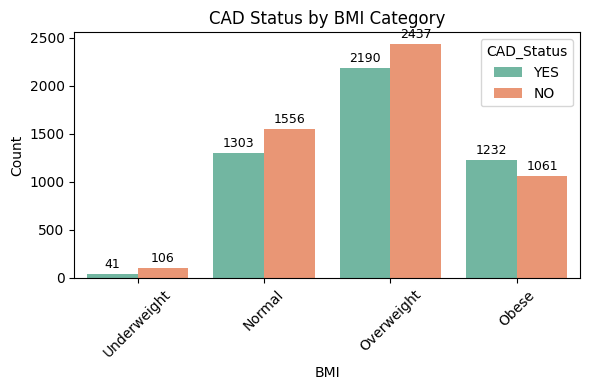

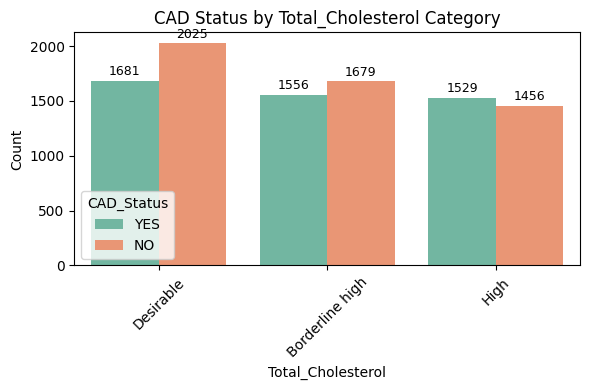

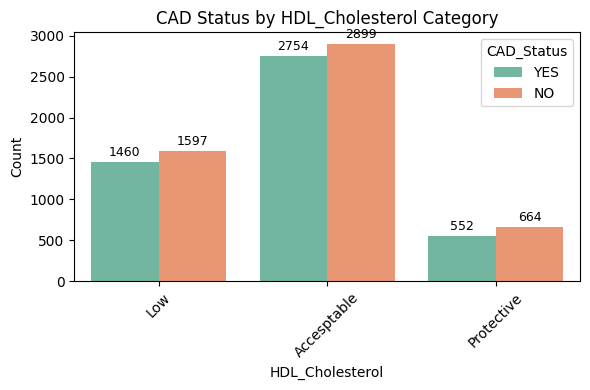

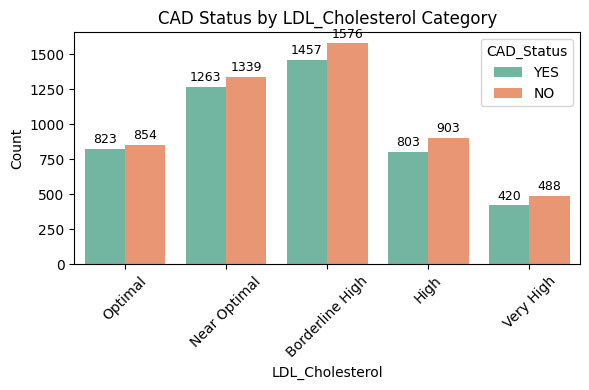

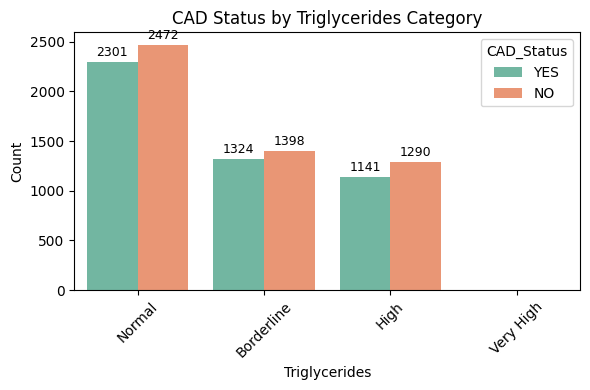

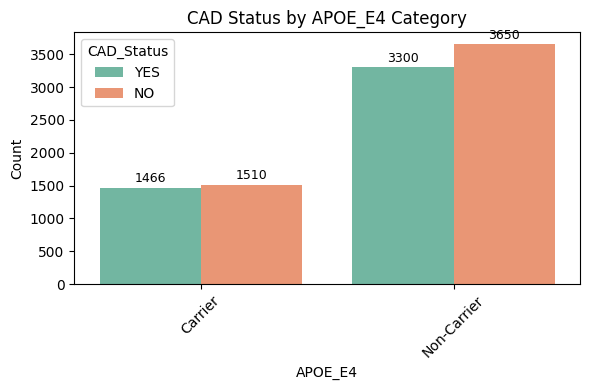

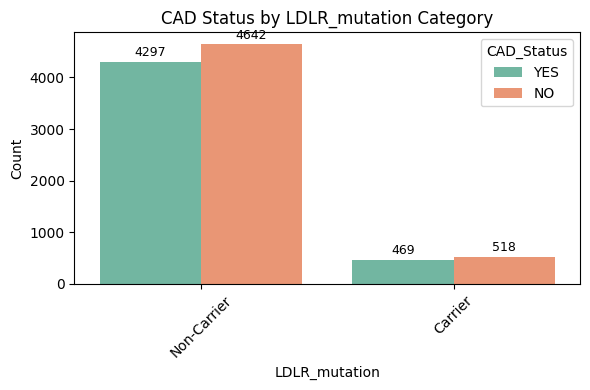

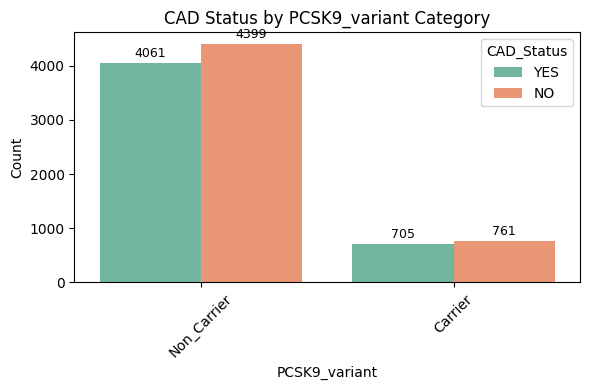

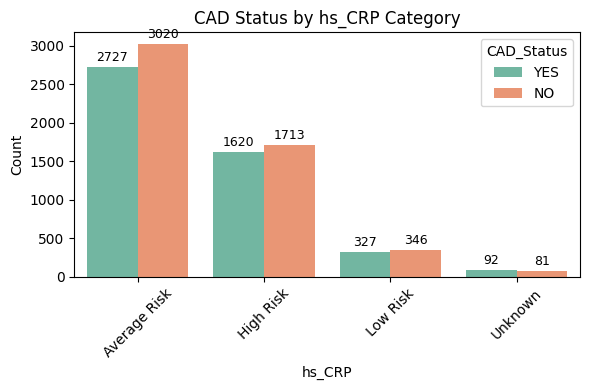

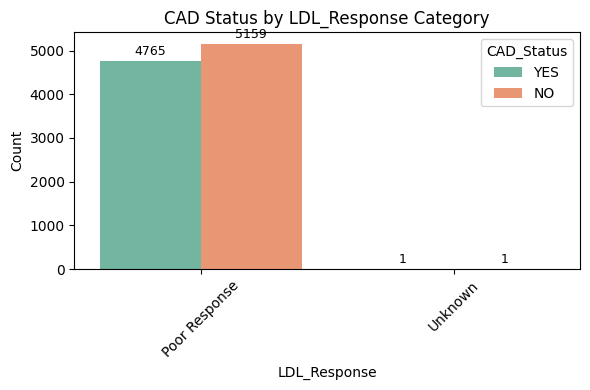

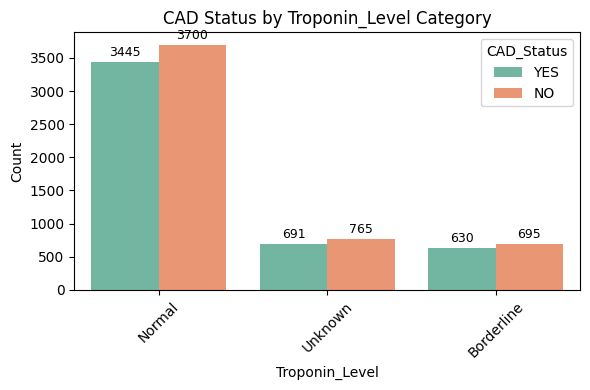

In [ ]:
# Distribution of proportion of CAD_Status for genetic features

for col in genetic_features:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=mba, x=col, hue='CAD_Status', palette='Set2')

    # Add counts above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

    plt.title(f'CAD Status by {col} Category', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



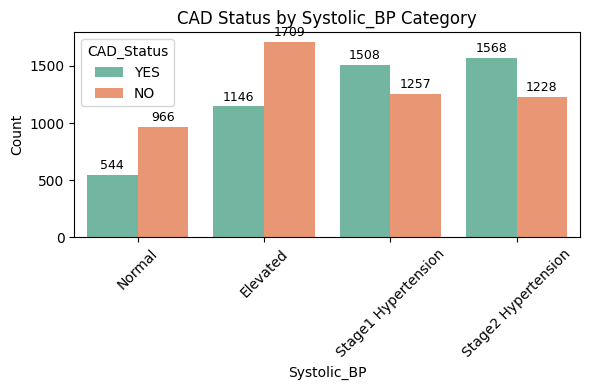

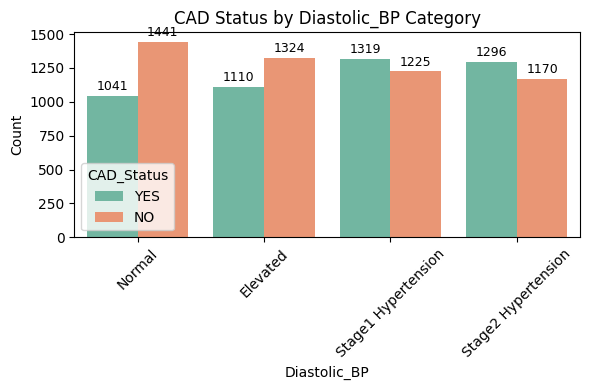

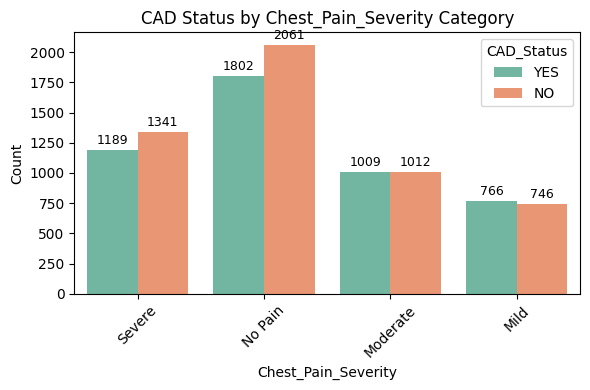

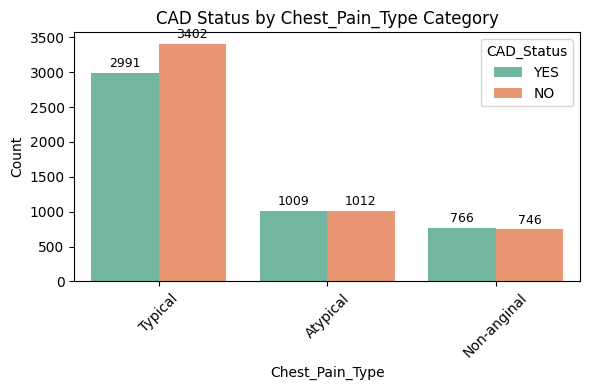

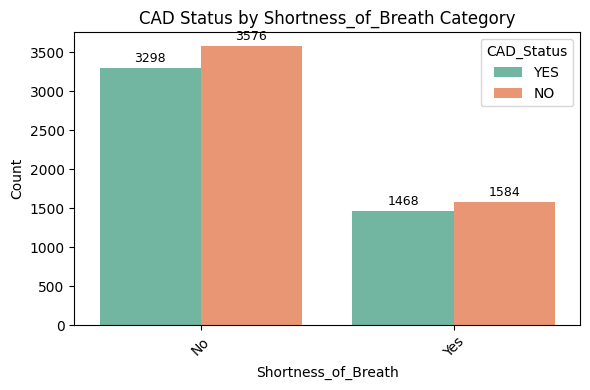

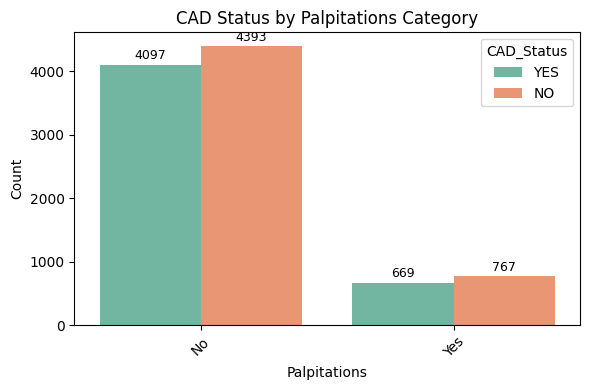

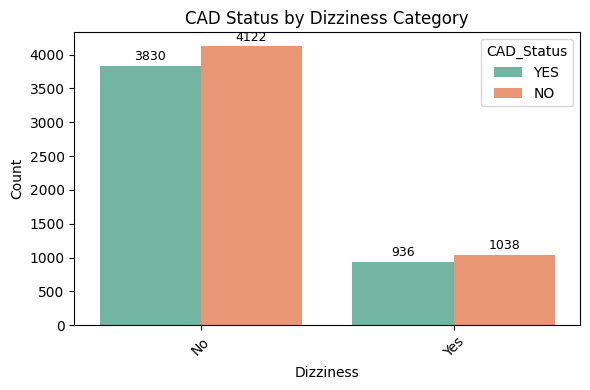

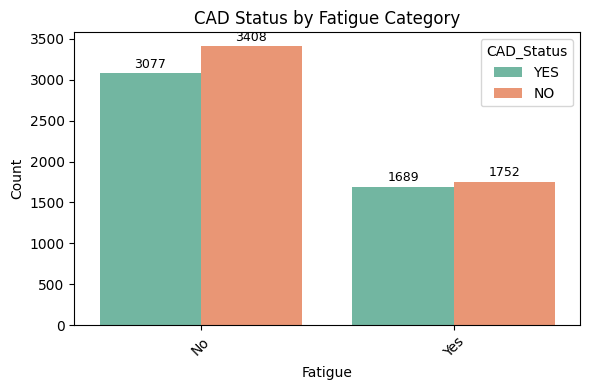

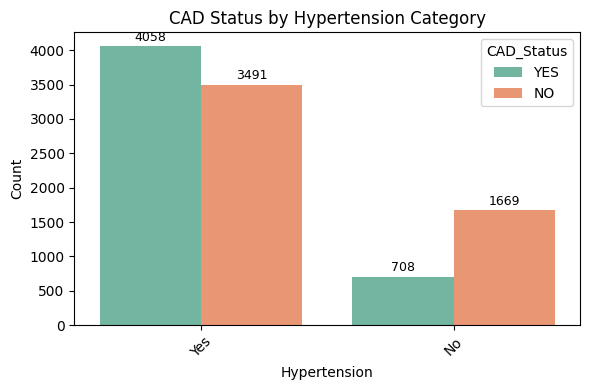

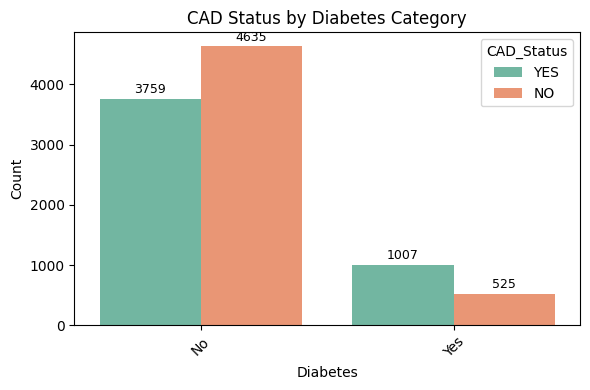

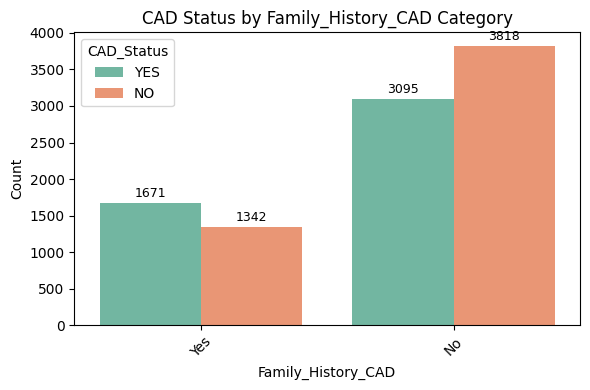

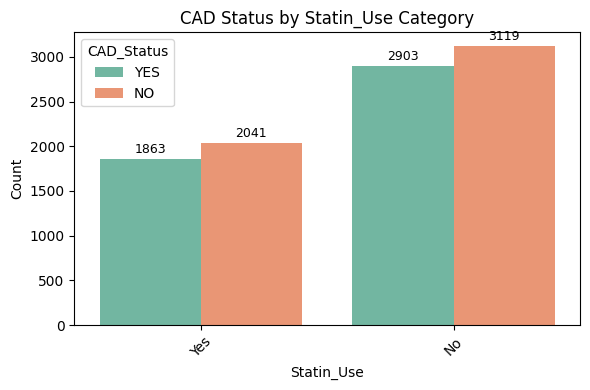

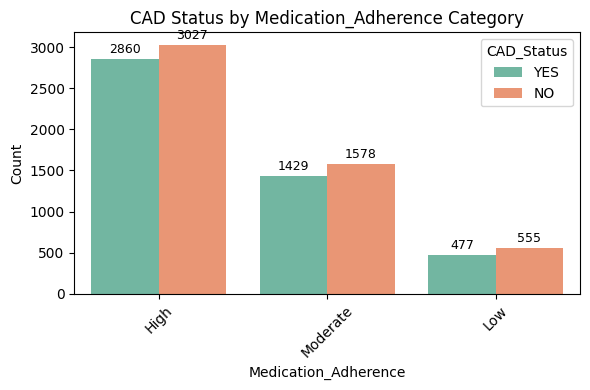

In [ ]:
for col in clinical_features:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=mba, x=col, hue='CAD_Status', palette='Set2')

    # Add counts above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

    plt.title(f'CAD Status by {col} Category', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

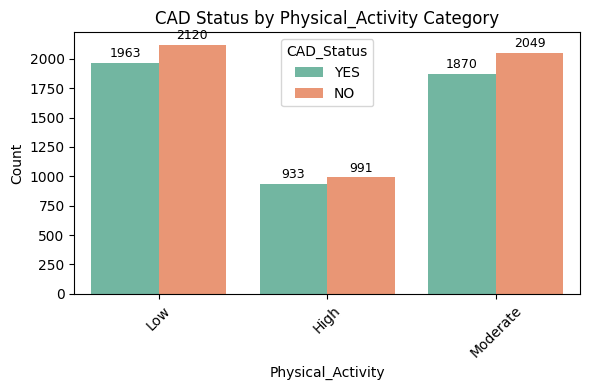

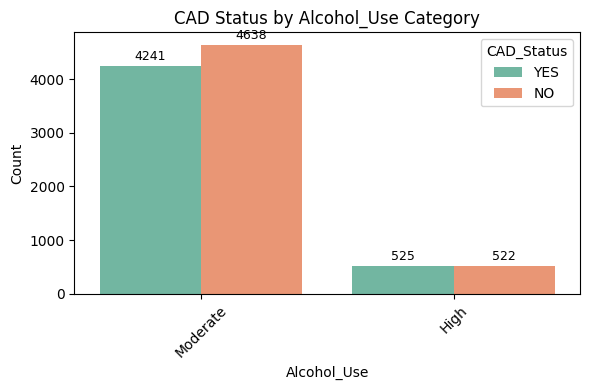

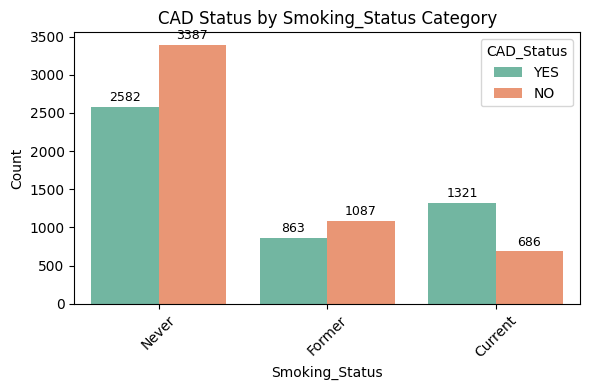

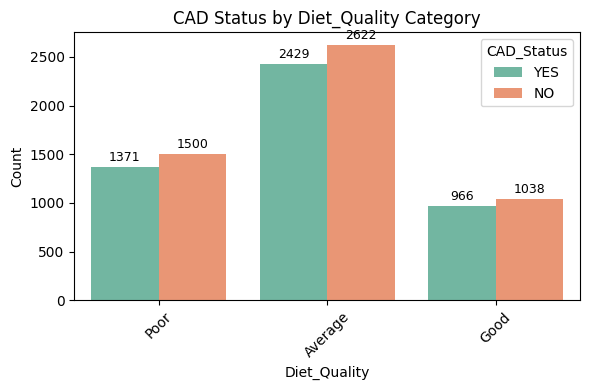

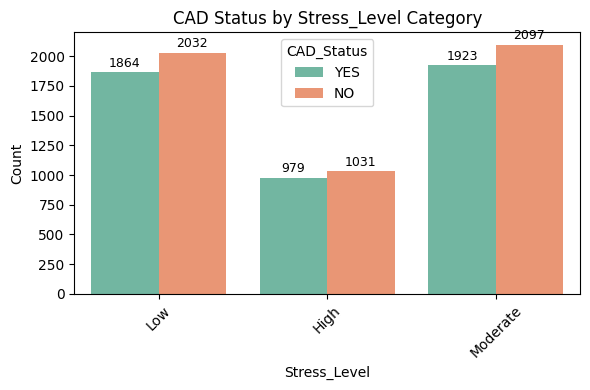

In [ ]:
for col in lifestyle_features:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=mba, x=col, hue='CAD_Status', palette='Set2')

    # Add counts above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

    plt.title(f'CAD Status by {col} Category', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

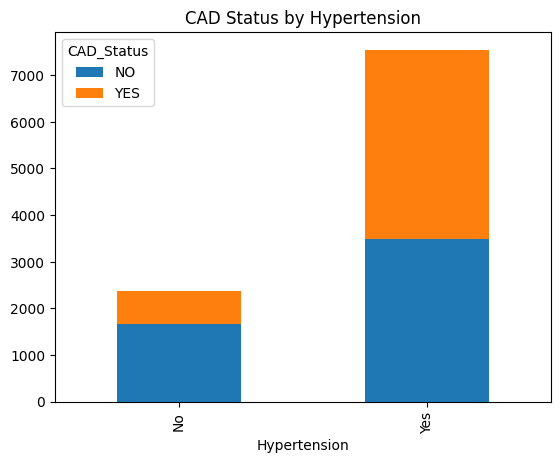

In [ ]:
pd.crosstab(mba['Hypertension'], mba['CAD_Status']).plot(kind='bar', stacked=True)
plt.title('CAD Status by Hypertension')
plt.show()


# Next Step:
Use the mba data now and do the rules mining

